In [ ]:
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode


## Install NeMo
!python -m pip install nemo_toolkit[all]

# !pip install torchtext==0.10.1
# !pip install matplotlib==3.1.3
"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

In [ ]:
# Папка, где будет размещаться датасет Golos
data_dir = '/content'

In [ ]:
import glob
import os
import subprocess
import tarfile
import wget

# Загрузка датасета Golos
def load(golos_url, fname):
  if not os.path.exists(os.path.join(data_dir, fname)):
      golos_path = wget.download(golos_url, os.path.join(data_dir, fname))
      print(f"Dataset downloaded at: {golos_path}")
  else:
      print("Tarfile already exists.")
      golos_path = os.path.join(data_dir, fname)
  return golos_path

golos_path = load("https://sc.link/Kqr", "test.tar")

if not os.path.exists(os.path.join(data_dir, '/test/')):
    tar = tarfile.open(golos_path)
    tar.extractall(path=data_dir)

Dataset downloaded at: /content/test.tar


In [ ]:
farfield_path = load("https://sc.link/1Z3", "farfield_train.tar")
if not os.path.exists(os.path.join(data_dir, '/farfield_train/')):
    tar = tarfile.open(farfield_path)
    tar.extractall(path=data_dir) 

Dataset downloaded at: /content/farfield_train.tar


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Теперь в папке `/content` должна размещаться папка `test` с тестовыми данных датасета Golos. Она содержит файлы манифесты `./test/crowd/manifest.jsonl`, `./test/farfield/manifest.jsonl` и аудио файлы в подпапках `./test/crowd/files/` и `./test/farfield/files/`.

Мы можем загрузить и посмотреть данные. Например файл `./test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav` это четырехсекундная запись мужчины, который произносит фразу `Купить моющее средство`. Чтобы убедиться в этом давайте послушаем запись:

In [ ]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav'

audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In [ ]:
file_farf = data_dir + '/train/farfield/f6075fae0c592183f107cf781117d9b5.wav'
audio, sample_rate = librosa.load(file_farf)
ipd.Audio(file_farf, rate=sample_rate)

В задаче распознавания речи, если этот WAV файлявляется нашим входом в систему, то фраза `Купить моющее средство` будет желаемым выходом из системы.

Давайте изобразим форму волны по точкам, которые содержатся в файлах. 
Этот формат отображения аудио, который скорее всего вам знаком, така как используется во многих аудио радакторах и плеерах:

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

ImportError: ignored

<Figure size 1080x504 with 1 Axes>

### Спектрограмма и мел-спектрограмма

Давайте применим [Фурье преобразование](https://en.wikipedia.org/wiki/Fourier_transform) к аудио сигналу, чтобы получить что то более полезное: **спектрограмму**, которая представляет собой величину энергии (амплитуда или громкость) для каждой частоты (гармоники) сигнала на каждом промежутке времени.

Спектрограмма (которую можно рассматривать как тепловую карту) является хорошим способом увидеть, как *амплитуды различных частот в звуке меняются с течением времени*. Спектрограмма получается путем разбиения сигнала на короткие фреймы, обычно перекрывающиеся и выполнения кратковременного преобразования Фурье (STFT) для каждого из фреймов.

Двайте посмотрим как выглядит спекторграмма для нашего звука. 

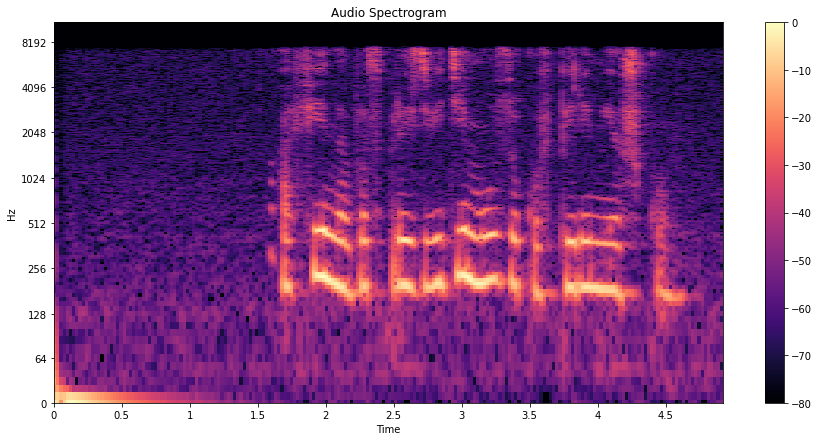

In [ ]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Можем сделать еще одну потенциально полезную настройку: использовать **Mel** спектрограмму вместо обычной спектрограммы. Это просто изменение шкалы частот, которую мы используем, с линейной (или логарифмической) на шкалу mel, которая представляет собой "шкалу восприятия тонов, которые слушатели оценивают как равные на расстоянии друг от друга" (из [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

Другими словами, это преобразование частот, чтобы быть более согласованным с тем, что воспринимают люди; изменение +1000 Гц с 2000 Гц->3000 Гц звучит для нас как большая разница, чем 9000 Гц->10000 Гц, поэтому шкала mel нормализует это так, что равные расстояния звучат как равные различия для человеческого уха. Интуитивно мы используем спектрограмму mel, потому что в этом случае мы обрабатываем и расшифровываем человеческую речь, так что преобразование шкалы для лучшего соответствия тому, что мы слышим, является полезной процедурой.

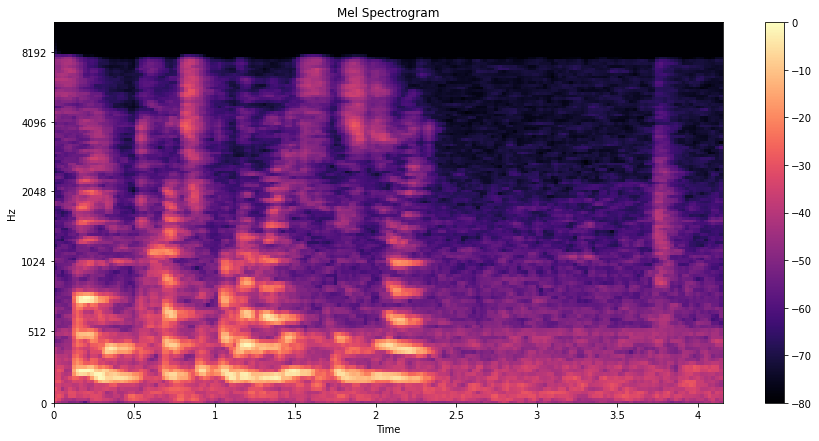

In [ ]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

## Сверточная модель распознавания речи
### Jasper модель

Мы будем тренировать небольшую модель [Jasper (Just Another SPeech Recognizer) model](https://arxiv.org/abs/1904.03288) с нуля (инициализируется случайным образом).
Архитектуры Jasper состоят из повторяющейся блочной структуры, которая использует 1D-свертки.
В модели Jasper_KxR подблоки `R` (состоящие из 1D свертки, batchnorm, ReLU и dropout) группируются в один блок, который затем повторяется `K` раз.
Также есть один дополнительный блок в начале и еще несколько в конце, которые инвариантны к `K` и `R`, идалее используем CTC loss.

### Модель QuartzNet

QuartzNet является улучшенным вариантом Jasper с ключевым отличием в том, что она использует 1D-свертки, разделяемые по временному каналу. Это позволяет ему значительно сократить количество весов при сохранении аналогичной точности.

Модели Jasper/QuartzNet выглядят так (на фото изображена модель QuartzNet):

![QuartzNet with CTC](https://developer.nvidia.com/blog/wp-content/uploads/2020/05/quartznet-model-architecture-1-625x742.png)

# Использование NeMo для распонавания речи

Теперь мы знаем что такое задача автоматичского распознавания речи и речевые данные, давайте использовать NeMo для распознавания речи.

Мы будем использовать **Neural Modules (NeMo) toolkit**, поэтому нужно скачать и установить все ее зависимости. Для этого следуйте инструкции в репозитории [GitHub page](https://github.com/NVIDIA/NeMo), или документации [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/).

NeMo позволяет нам легко использовать все необходимые компоненты для нашей модели: dataloader,  промежуточные сверточные или рекурентные слои, разные loss  функции без необходимости разбираться в деталях реализации разных моедлей. В NeMo содержатся готовые реализованные модели в которых достаточно подать свои данные и задать гиперпараметры для обучения.

In [ ]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

[NeMo W 2021-11-29 11:15:59 optimizers:50] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



## Исползование предобученной модели


Коллекция для распознавания речи в NeMo содержит готовые блоки, которые можно использовать чтобы тренировать и использовать свою модель. Кроме этого существет ряд предобученных моделей, которые можно просто скачать и исползовать. Давайте скачаем и инициализируем готовую модель QuartzNet15x5, обученную на открытом датасете Golos.



In [ ]:
# asr_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_ru_quartznet15x5")

load("https://sc.link/ZMv", "QuartzNet15x5_golos.nemo")
asr_model = nemo_asr.models.EncDecCTCModel.restore_from(os.path.join(data_dir, "QuartzNet15x5_golos.nemo"))

Tarfile already exists.


[NeMo W 2021-11-29 14:36:27 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: train/golos_and_mcv.jsonl
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 64
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    num_workers: 20
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    parser: ru
    
[NeMo W 2021-11-29 14:36:27 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a

[NeMo I 2021-11-29 14:36:27 features:265] PADDING: 16
[NeMo I 2021-11-29 14:36:27 features:282] STFT using torch
[NeMo I 2021-11-29 14:36:28 save_restore_connector:149] Model EncDecCTCModel was successfully restored from /content/QuartzNet15x5_golos.nemo.


Теперь указваем список фалов которые мы хотим транскрибировать и передаем в нашу модель. Это будет работать для относительно коротких аудио (<25 секунд) файлов. 

In [ ]:
files = [data_dir + "/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav",
         data_dir + "/test/crowd/files/5db5df8bb9e3b6660b2a04b34d4a355d.wav"]
transcriptions = asr_model.transcribe(paths2audio_files=files)

for fname, transcription in zip(files, transcriptions):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-11-29 14:36:29 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


Audio in /content/test/crowd/files/e632f7d39c15e7edfc665b91e6f2071f.wav was recognized as: афина воспроизведи музыку вперемешку
Audio in /content/test/crowd/files/5db5df8bb9e3b6660b2a04b34d4a355d.wav was recognized as: найти сериал григорий р


Это было просто! Но существует масса сценариев, когда мы хотим дообучить модель на наших данных или обучить заново. Например это модель не сможет распознать украинский язык и скоре всего будет плохо распознавать речь в телефонных разговорах. Поэтому, если вы применяете модель на своих данных, то без сомнения, вам нужно дообучать модель на них!

## Обучение 


Для обучения нужно подготовить данные в нужном формате. Для этого добавим абсолютные пути к относительным в наших манифестах и используем их для обучения.

In [ ]:
# --- Building Manifest Files --- #
import json
import random 
# Function to build a manifest
def build_manifest(manifest_rel, manifest_abs, flag=False):
    manifest_path = os.path.split(os.path.abspath(manifest_rel))[0]
    with open(manifest_rel, 'r') as fin:
        with open(manifest_abs, 'w') as fout:
            n = 0
            for line in fin:
                rand = random.random()
                if rand > 0.3:
                  continue
                if flag:
                  if n > 30000:
                    break
                metadata = json.loads(line)
                if metadata['id'] == '375e547e51a71f9e18b811dd89244baf':
                  continue
                metadata["audio_filepath"]=os.path.join(manifest_path, metadata["audio_filepath"])
                json.dump(metadata, fout)
                fout.write('\n')
                n += 1
                
                
# Building Manifests
print("******")
train_rel = os.path.join(data_dir, 'train/manifest_farfield.jsonl')
train_abs = os.path.join(data_dir, 'train/farfield_train.jsonl')
if not os.path.isfile(train_abs):
  build_manifest(train_rel, train_abs, True)
train_manifest = train_abs
print("train_manifest", train_manifest)

train_rel = os.path.join(data_dir, 'test/farfield/manifest.jsonl')
train_abs = os.path.join(data_dir, 'test/farfield/farfield_test.jsonl')
if not os.path.isfile(train_abs):
  build_manifest(train_rel, train_abs)
test_manifest = train_abs
print("test_manifest", test_manifest)

******
train_manifest /content/train/farfield_train.jsonl
test_manifest /content/test/farfield/farfield_test.jsonl


In [ ]:
# ! head /content/test/farfield/manifest.jsonl
! echo 'train'
! head /content/train/farfield_train.jsonl

train
{"id": "2599a6cb55795b38ddd80b849d8670bc", "audio_filepath": "/content/train/farfield/2599a6cb55795b38ddd80b849d8670bc.wav", "text": "\u0434\u0436\u043e\u0439 \u043a\u0430\u043a\u0430\u044f \u0432\u0430\u043b\u044e\u0442\u0430 \u0432 \u043a\u0430\u043c\u0431\u043e\u0434\u0436\u0435", "duration": 3.9185625}
{"id": "5f7483035b2f26b773b0d3fb125b779d", "audio_filepath": "/content/train/farfield/5f7483035b2f26b773b0d3fb125b779d.wav", "text": "\u0441\u0430\u043b\u044e\u0442 \u044f \u043c\u043e\u0433\u0443 \u0447\u0442\u043e \u043d\u0438\u0431\u0443\u0434\u044c \u0441\u0434\u0435\u043b\u0430\u0442\u044c", "duration": 5.063625}
{"id": "90655e9a042c4e79c424cd7dd82b37a6", "audio_filepath": "/content/train/farfield/90655e9a042c4e79c424cd7dd82b37a6.wav", "text": "\u0441\u0430\u043b\u044e\u0442 \u043d\u0430 \u043a\u0430\u043a\u043e\u043c \u044f\u0437\u044b\u043a\u0435 \u0441\u043e\u0437\u0434\u0430\u043d\u0430 \u043a\u0430\u0432\u043a\u0430 \u043d\u0430 \u043f\u043b\u044f\u0436\u0435", "durat

In [ ]:
! echo 'test'
! head /content/test/farfield/farfield_test.jsonl 

test
{"id": "58b586f67f5e634506e215df5996b82e", "audio_filepath": "/content/test/farfield/files/58b586f67f5e634506e215df5996b82e.wav", "text": "\u0434\u0436\u043e\u0439 \u0445\u0432\u0430\u0442\u0438\u0442", "duration": 1.696625}
{"id": "94f4ad577967f9f61d5d88cd92b1339c", "audio_filepath": "/content/test/farfield/files/94f4ad577967f9f61d5d88cd92b1339c.wav", "text": "\u0441\u0431\u0435\u0440 \u043c\u043d\u0435 \u043d\u0440\u0430\u0432\u0438\u0442\u0441\u044f", "duration": 1.9945}
{"id": "18daa690cdf99e5fc8fa7fba9bf3995f", "audio_filepath": "/content/test/farfield/files/18daa690cdf99e5fc8fa7fba9bf3995f.wav", "text": "\u0434\u0436\u043e\u0439 \u043f\u0440\u0438\u043b\u043e\u0436\u0435\u043d\u0438\u0435 \u0441\u0432\u0435\u0440\u043d\u0438", "duration": 1.8750625}
{"id": "e7b833d06926ceaf61a7208cd3ce56fb", "audio_filepath": "/content/test/farfield/files/e7b833d06926ceaf61a7208cd3ce56fb.wav", "text": "\u0434\u0436\u043e\u0439 \u043d\u0430\u0434\u043e\u0435\u043b", "duration": 1.6078125}
{"i

### Задаем модель при помощи YAML конфиг файла


Ниже приведен конфиг файл, давайте рассмотрим его и найдем части описанной архитектуры Jasper. Модель (model) содержит поле под названием `encoder` с под-полем `jasper` который состоит из списка полей. Каждое поле в списке задает конфигурацию блока в нашей моделе. Каждый блок выглядит примерно так:

```
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```


Первый элемент в спике соответствует первому блоку в Jasper архитектуре.

Параметры обучающего и тестового датасета в полях (`train_ds`) и (`validation_ds`)

Конфиг в формате YAML позволяем легко и в читаемой форме читать и модифицировать модель без необходимости менять код пррограммы.

### Использование PyTorch Lightning

NeMo модели и модули могуть исползоваться в любом PyTorch проекте где ожидается тип torch.nn.Module.

Однако, NeMo модели созданы на основе [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule, поэтому рекомендуется использовать PytorchLightning для обучения и дообучения (fine-tuning) так как это позволяет легко применять mixed precision и распределенное обучение. Давайте создадим объект Trainer для обучения на GPU 5 эпох.

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=1, precision=16, default_root_dir="/content/drive/MyDrive/checkpoints")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
params_model = asr_model._cfg

# --- Config Information ---#
# try:
#     from ruamel.yaml import YAML
# except ModuleNotFoundError:
#     from ruamel_yaml import YAML
# config_path = '/usr/local/lib/python3.7/dist-packages/nemo/collections/asr/models/configs/'

# yaml = YAML(typ='safe')
# with open(config_path) as f:
#     params = yaml.load(f)
# print(params)
params_model['train_ds']['parser']='base'
params_model['validation_ds']['parser']='base'
params_model['test_ds']['parser']='base'
params_model['train_ds']['manifest_filepath'] = train_manifest
params_model['train_ds']['batch_size']=16
params_model['validation_ds']['manifest_filepath'] = test_manifest
params_model['validation_ds']['batch_size']=16
params_model['test_ds']['manifest_filepath'] = test_manifest
params_model['test_ds']['batch_size']=16

In [ ]:
params_model

{'sample_rate': 16000, 'repeat': 5, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'optim': {'name': 'novograd', 'lr': 0.05, 'betas': [0.9, 0.98], 'weight_decay': 0.001, 'sched': {'name': 'CosineAnnealing', 'warmup_steps': 500, 'warmup_ratio': None, 'min_lr': 0.0, 'last_epoch': -1}}, 'train_ds': {'manifest_filepath': '/content/train/farfield_train.jsonl', 'sample_rate': 16000, 'labels': [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я'], 'batch_size': 16, 'trim_silence': False, 'max_duration': 20.0, 'min_duration': 0.1, 'num_workers': 20, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'tarred_shard_strategy': 'scatter', 'parser': 'base'}, 'validation_ds': {'manifest_filepath': '/content/te

In [ ]:
params_model['optim']['lr'] = 0.0005

Затем мы создадим экземпляр и модель ASR на основе нашего файла ``config.yaml`` из предыдущего раздела. 
Обратите внимание, что это этап, на котором мы также сообщаем модели, где находятся наши обучающие и тестовые манифесты.

In [ ]:
from omegaconf import DictConfig

first_asr_model = asr_model

In [ ]:
import copy
opt = copy.deepcopy(params_model['optim'])
opt['lr'] = 0.0001
first_asr_model.setup_optimization(optim_config=DictConfig(opt))

[NeMo W 2021-11-29 14:42:14 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-29 14:42:14 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-29 14:42:14 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.9, 0.98]
     eps: 1e-08
     grad_averaging: False
     lr: 0.0001
     weight_decay: 0.001
 ), None)

In [ ]:
first_asr_model.setup_training_data(train_data_config=params_model['train_ds'])
first_asr_model.setup_test_data(test_data_config=params_model['test_ds'])
# Point to the new validation data for fine-tuning
first_asr_model.setup_validation_data(val_data_config=params_model['validation_ds'])

[NeMo I 2021-11-29 14:42:20 collections:173] Dataset loaded with 29999 files totalling 32.82 hours
[NeMo I 2021-11-29 14:42:20 collections:174] 2 files were filtered totalling 0.01 hours


[NeMo W 2021-11-29 14:42:20 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


[NeMo I 2021-11-29 14:42:20 collections:173] Dataset loaded with 545 files totalling 0.40 hours
[NeMo I 2021-11-29 14:42:20 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-11-29 14:42:20 collections:173] Dataset loaded with 545 files totalling 0.40 hours
[NeMo I 2021-11-29 14:42:20 collections:174] 0 files were filtered totalling 0.00 hours


In [ ]:
# Bigger batch-size = bigger throughput
# params['model']['validation_ds']['batch_size'] = 16
# Setup the test data loader and make sure the model is on GPU
# first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        first_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-29 13:03:03 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


WER = 0.9984490575041756


Мы можем начать обучение всего одной строчкой!

In [ ]:
# Start training!!!
trainer.fit(first_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-11-29 14:42:36 modelPT:453] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-29 14:42:36 modelPT:561] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )


[NeMo W 2021-11-29 14:42:36 lr_scheduler:732] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 34.9 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
37.859    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-11-29 14:42:37 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    
[NeMo W 2021-11-29 14:42:39 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
first_asr_model.save_to('/content/drive/MyDrive/model_first_30000_1.nemo')

In [ ]:
# Bigger batch-size = bigger throughput
# params['model']['validation_ds']['batch_size'] = 16
# Setup the test data loader and make sure the model is on GPU
# first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        first_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo W 2021-11-29 15:42:46 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/nemo/collections/asr/parts/submodules/jasper.py:280: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
      ) // self.conv.stride[0] + 1
    


WER = 0.53811289658014
